In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = "final_data_for_analysis.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Claim_Date                 781 non-null    object
 1   Employee_Name              786 non-null    object
 2   Employee_ID                786 non-null    int64 
 3   Designation                786 non-null    object
 4   Project_Name               706 non-null    object
 5   Email_address              785 non-null    object
 6   Total_Persons              786 non-null    int64 
 7   Allowable_Amount           786 non-null    int64 
 8   Total_Bill_Amount          786 non-null    object
 9   List_of_Persons_(as JSON)  767 non-null    object
 10  Seating_Location           786 non-null    object
 11  Bill_Date                  786 non-null    object
 12  Bill_No                    784 non-null    object
 13  Bill_day                   786 non-null    object
 14  Computed_T

In [8]:
# Convert date columns to datetime format
date_columns = ['Claim_Date', 'Bill_Date', 'Bill_Date_Friday']
df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%d-%m-%Y', errors='coerce')

# Convert numerical columns to integer or float
df['Employee_ID'] = df['Employee_ID'].astype('int64')
df['Total_Persons'] = df['Total_Persons'].astype('int64')
df['Allowable_Amount'] = df['Allowable_Amount'].astype('int64')
df['Computed_Total_Persons'] = df['Computed_Total_Persons'].astype('int64')

# Convert 'Total_Bill_Amount' to numeric (handling non-numeric cases)
df['Total_Bill_Amount'] = pd.to_numeric(df['Total_Bill_Amount'], errors='coerce')

# Convert 'Mismatch' to boolean
df['Mismatch'] = df['Mismatch'].astype('bool')

# Fill missing values in categorical columns with 'Unknown'
categorical_columns = ['Project_Name', 'Email_address', 'Bill_No']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')


In [9]:
# Calculate per-person expenditure
df['Per_Person_Expenditure'] = df['Total_Bill_Amount'] / df['Total_Persons']

In [10]:
# Group by group size and calculate average per-person expenditure
group_size_analysis = df.groupby('Total_Persons')['Per_Person_Expenditure'].agg(['mean', 'count']).reset_index()
group_size_analysis.columns = ['Group_Size', 'Avg_Per_Person_Expenditure', 'Count']

In [11]:
# Calculate percentage change from individual claims
base_value = group_size_analysis.loc[group_size_analysis['Group_Size'] == 1, 'Avg_Per_Person_Expenditure'].values[0]
group_size_analysis['Percentage_Change'] = ((group_size_analysis['Avg_Per_Person_Expenditure'] - base_value) / base_value * 100).round(2)


c:\Users\DYNABOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


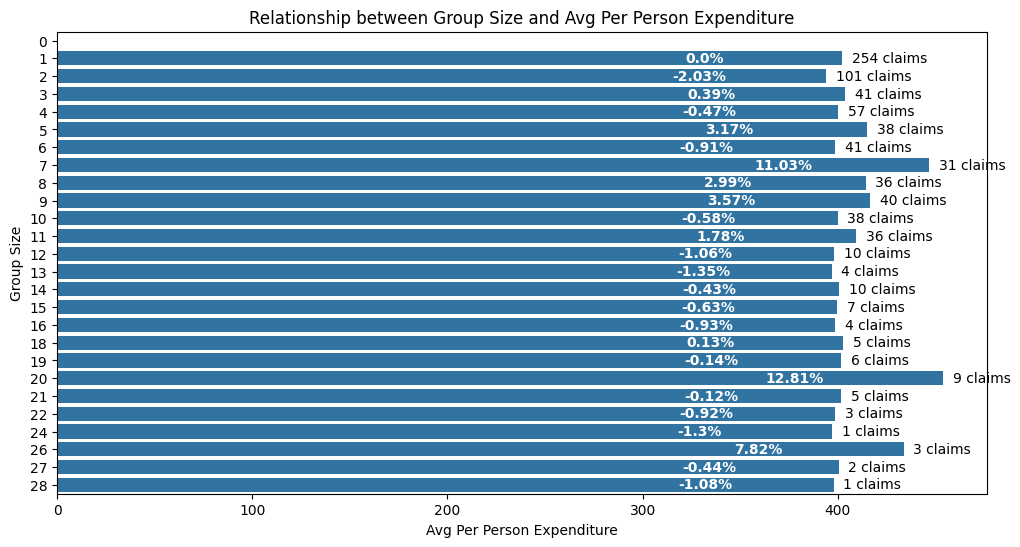

In [12]:
plt.figure(figsize=(12, 6))

# Create horizontal bar plot
sns.barplot(y='Group_Size', x='Avg_Per_Person_Expenditure', data=group_size_analysis, orient='h')

# Add labels for count and percentage change
for i, row in enumerate(group_size_analysis.itertuples()):
    # Claims label (placed to the right of the bar)
    plt.text(row.Avg_Per_Person_Expenditure + 5, i, f'{row.Count} claims', va='center')

    # Percentage change label (placed inside the bar, shifted left for readability)
    plt.text(row.Avg_Per_Person_Expenditure * 0.8, i, f'{row.Percentage_Change}%', va='center', color='white', fontweight='bold')

# Show plot
plt.xlabel('Avg Per Person Expenditure')
plt.ylabel('Group Size')
plt.title('Relationship between Group Size and Avg Per Person Expenditure')
plt.show()

In [18]:
# Step 1: Replace inf values with NaN
group_size_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Drop rows with NaN values (including previously inf values)
group_size_analysis.dropna(inplace=True)

# Step 3: Recalculate correlation
correlation = group_size_analysis['Group_Size'].corr(group_size_analysis['Avg_Per_Person_Expenditure'])

print(f"Correlation: {correlation}")

Correlation: 0.03706067250660203


In [18]:
print("\nBasic Analysis Results:")
print(group_size_analysis[['Group_Size', 'Avg_Per_Person_Expenditure', 'Count', 'Percentage_Change']])


Basic Analysis Results:
    Group_Size  Avg_Per_Person_Expenditure  Count  Percentage_Change
0            0                         inf      2                inf
1            1                  402.193819    254               0.00
2            2                  394.031188    101              -2.03
3            3                  403.755854     41               0.39
4            4                  400.307018     57              -0.47
5            5                  414.952632     38               3.17
6            6                  398.520325     41              -0.91
7            7                  446.544608     31              11.03
8            8                  414.215278     36               2.99
9            9                  416.566667     40               3.57
10          10                  399.873684     38              -0.58
11          11                  409.338384     36               1.78
12          12                  397.916667     10              -1.06
13       